In [267]:
import pandas as pd
import numpy as np
import plotly.express as px
from tinyshift.series import adi_cv, theoretical_limit, foreca, stability_index, hurst_exponent, trend_significance
from utilsforecast.preprocessing import fill_gaps
from utilsforecast.data import generate_series
from statsmodels.tsa.stattools import adfuller, acf, pacf
from tinyshift.plot import corr_heatmap
import holidays
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp

In [268]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)

In [269]:
df.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

In [270]:
df

,ds,y,unique_id
0,1949-01-01,112,1
1,1949-02-01,118,1
2,1949-03-01,132,1
3,1949-04-01,129,1
4,1949-05-01,121,1
...,...,...,...
139,1960-08-01,606,1
140,1960-09-01,508,1
141,1960-10-01,461,1
142,1960-11-01,390,1


In [271]:
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")

In [272]:
def remove_leading_zeros(group):
    """
    Removes leading zeros from series
    """
    first_non_zero_index = group["y"].ne(0).idxmax()
    return group.loc[first_non_zero_index:]

In [273]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [274]:
def is_obsolete(group, days_obsoletes):
    """
    Identify obsolote series
    """
    last_date = group["ds"].max()
    cutoff_date = last_date - pd.Timedelta(days=days_obsoletes)
    recent_data = group[group["ds"] >= cutoff_date]
    return (recent_data["y"] ==0).all()

In [275]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [276]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [277]:
obsolote_ids

[]

In [278]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [279]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [280]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [281]:
def forecastability(X):
    """
    Calculate forecastability metrics for a time series.
    """
    return {"foreCA": foreca(X),
     "theoretical_limit": theoretical_limit(X),
     "stability_index": stability_index(X, detrend=True),
     "adi_cv": adi_cv(X),
     "hurst_exponent": hurst_exponent(X)}

In [282]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
1          foreCA                                               0.571263
           theoretical_limit                                    0.086973
           stability_index                                      0.183962
           adi_cv                             (1.0, 0.18190737443351804)
           hurst_exponent       (0.5203628364992473, 0.8044229708616066)
Name: y, dtype: object

# ADF Test - Order of Diff 1

In [284]:
def generate_lag(X, lag=1):
    X = np.asarray(X, dtype=np.float64)

    if X.ndim > 1:
        raise ValueError("Input array must be one-dimensional.")

    return np.concatenate((np.nan * np.ones(lag), (X[lag:] - X[:-lag])))

In [285]:
df["lag_1"] = df["y"].pipe(generate_lag, lag=1)
df["lag_12"] = df["lag_1"].pipe(generate_lag, lag=12)
#df = df.dropna()

In [286]:
df

,unique_id,ds,y,lag_1,lag_12
0,1,1949-01-01,112,NaN,NaN
1,1,1949-02-01,118,6.0,NaN
2,1,1949-03-01,132,14.0,NaN
3,1,1949-04-01,129,-3.0,NaN
4,1,1949-05-01,121,-8.0,NaN
...,...,...,...,...,...
139,1,1960-08-01,606,-16.0,-27.0
140,1,1960-09-01,508,-98.0,-2.0
141,1,1960-10-01,461,-47.0,9.0
142,1,1960-11-01,390,-71.0,-26.0


In [287]:
#df.groupby("unique_id")["lag_1"].apply(adfuller)

# Domingo

- #TODO: Adicionar gráfico de STL
- #TODO: Interpretar
- #TODO: Adicionar gráficos da aula do valeriy
- #TODO: Comparativo de dados diferenciados
- #TODO: Trazer gráficos de ipynbs dele

In [288]:
def plot_acf_pacf_adf(df, variables, fig_type=None):

    def create_acf_pacf_traces(data, nlags=30, color=None):
        n = len(data)
        conf = 1.96 / np.sqrt(n)
        acf_vals = acf(data, nlags=nlags)
        pacf_vals = pacf(data, nlags=nlags, method='yw')

        acf_bar = go.Bar(x=list(range(len(acf_vals))), y=acf_vals, marker_color=color)
        pacf_bar = go.Bar(x=list(range(len(pacf_vals))), y=pacf_vals, marker_color=color)

        band_upper = go.Scatter(x=list(range(nlags+1)), y=[conf]*(nlags+1),
                                mode='lines', line=dict(color='gray', dash='dash'), showlegend=False)
        band_lower = go.Scatter(x=list(range(nlags+1)), y=[-conf]*(nlags+1),
                                mode='lines', line=dict(color='gray', dash='dash'), showlegend=False)

        return acf_bar, pacf_bar, band_upper, band_lower
    
    # Criar títulos dos subplots corretamente
    subplot_titles = []
    for var in variables:
        subplot_titles.extend([f"Series ({var})", f"ACF ({var})", f"PACF ({var})"])
    subplot_titles.extend(["ADF Results Summary", "", ""])

    fig = sp.make_subplots(
        rows=len(variables) + 1, cols=3,
        subplot_titles=subplot_titles
    )

    # Calcular ADF results primeiro
    adf_results = {}
    
    for i, var in enumerate(variables, start=1):
        X = df[var].dropna()
        adf_stat, p_value = adfuller(X)[:2]
        adf_results[var] = f"ADF={adf_stat:.4f}, p={p_value:.4f}"
        # Série temporal
        fig.add_trace(
            go.Scatter(x=X.index, y=X, mode='lines', name=var, showlegend=False, line=dict(color='orange')), 
            row=i, col=1
        )
        
        # ACF e PACF
        acf_values, pacf_values, conf_up, conf_lo = create_acf_pacf_traces(X, color='orange')
        
        fig.add_trace(acf_values, row=i, col=2)
        fig.add_trace(pacf_values, row=i, col=3)
        fig.add_trace(conf_up, row=i, col=2)
        fig.add_trace(conf_lo, row=i, col=2)
        fig.add_trace(conf_up, row=i, col=3)
        fig.add_trace(conf_lo, row=i, col=3)

    adf_text = "<br>".join([f"<b>{k}</b>: {v}" for k, v in adf_results.items()])

    # Row 4 - ADF summary as annotation
    fig.add_trace(go.Scatter(
        x=[0], y=[0], text=[adf_text],
        mode='text', showlegend=False
    ), row=len(variables) + 1, col=1)

    # Layout
    fig.update_layout(
        title="ACF/PACF Across Differencing Stages with ADF Summary",
        height=1200,
        width=1300,
        showlegend=False
    )

    # Axis labels
    for row in range(1, 3):
        fig.update_xaxes(title_text="Date", row=row, col=1)
        fig.update_yaxes(title_text="Value", row=row, col=1)
        fig.update_xaxes(title_text="Lag", row=row, col=2)
        fig.update_xaxes(title_text="Lag", row=row, col=3)
        fig.update_yaxes(title_text="ACF", row=row, col=2)
        fig.update_yaxes(title_text="PACF", row=row, col=3)

    fig.update_xaxes(visible=False, row=4, col=1)
    fig.update_yaxes(visible=False, row=4, col=1)

    return fig.show(fig_type)

In [289]:
plot_acf_pacf_adf(df, ["y", "lag_1", "lag_12"])

## Features
- STL
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- ~~Lags~~
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [290]:
def add_in_date_information(df, time_col):
    """
    Adds date-based features to the dataframe
    """
    df = df.copy()
    holidays_br = holidays.country_holidays("Brazil")
    df['month'] = df[time_col].dt.month
    df["is_holiday"] = np.array([timestamp in holidays_br for timestamp in df["ds"]])
    df["is_month_end"] = df[time_col].dt.is_month_end

    #Cyclical encoding for day of week (weekly sensasonality) and day of year (yearly seasonality)
    df["dow_sin"] = np.sin(2 * np.pi * df[time_col].dt.dayofweek / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df[time_col].dt.dayofweek / 7)

    df["yr_sin"] = np.sin(2 * np.pi * df[time_col].dt.dayofyear / 12)
    df["yr_cos"] = np.cos(2 * np.pi * df[time_col].dt.dayofyear / 12)
    return df

In [293]:
df = df.pipe(add_in_date_information, "ds")
df = df.dropna()

In [295]:
df

,unique_id,ds,y,lag_1,lag_12,month,is_holiday,is_month_end,dow_sin,dow_cos,yr_sin,yr_cos
13,1,1950-02-01,126,11.0,5.0,2,False,False,0.974928,-0.222521,-8.660254e-01,-0.500000
14,1,1950-03-01,141,15.0,1.0,3,False,False,0.974928,-0.222521,-4.777360e-15,1.000000
15,1,1950-04-01,135,-6.0,-3.0,4,False,False,-0.974928,-0.222521,-5.000000e-01,-0.866025
16,1,1950-05-01,125,-10.0,-2.0,5,True,False,0.000000,1.000000,5.000000e-01,0.866025
17,1,1950-06-01,149,24.0,10.0,6,False,False,0.433884,-0.900969,-8.660254e-01,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1960-08-01,606,-16.0,-27.0,8,False,False,0.000000,1.000000,-8.660254e-01,0.500000
140,1,1960-09-01,508,-98.0,-2.0,9,False,False,0.433884,-0.900969,5.000000e-01,-0.866025
141,1,1960-10-01,461,-47.0,9.0,10,False,False,-0.974928,-0.222521,-5.000000e-01,0.866025
142,1,1960-11-01,390,-71.0,-26.0,11,False,False,0.781831,0.623490,9.798412e-15,-1.000000


/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



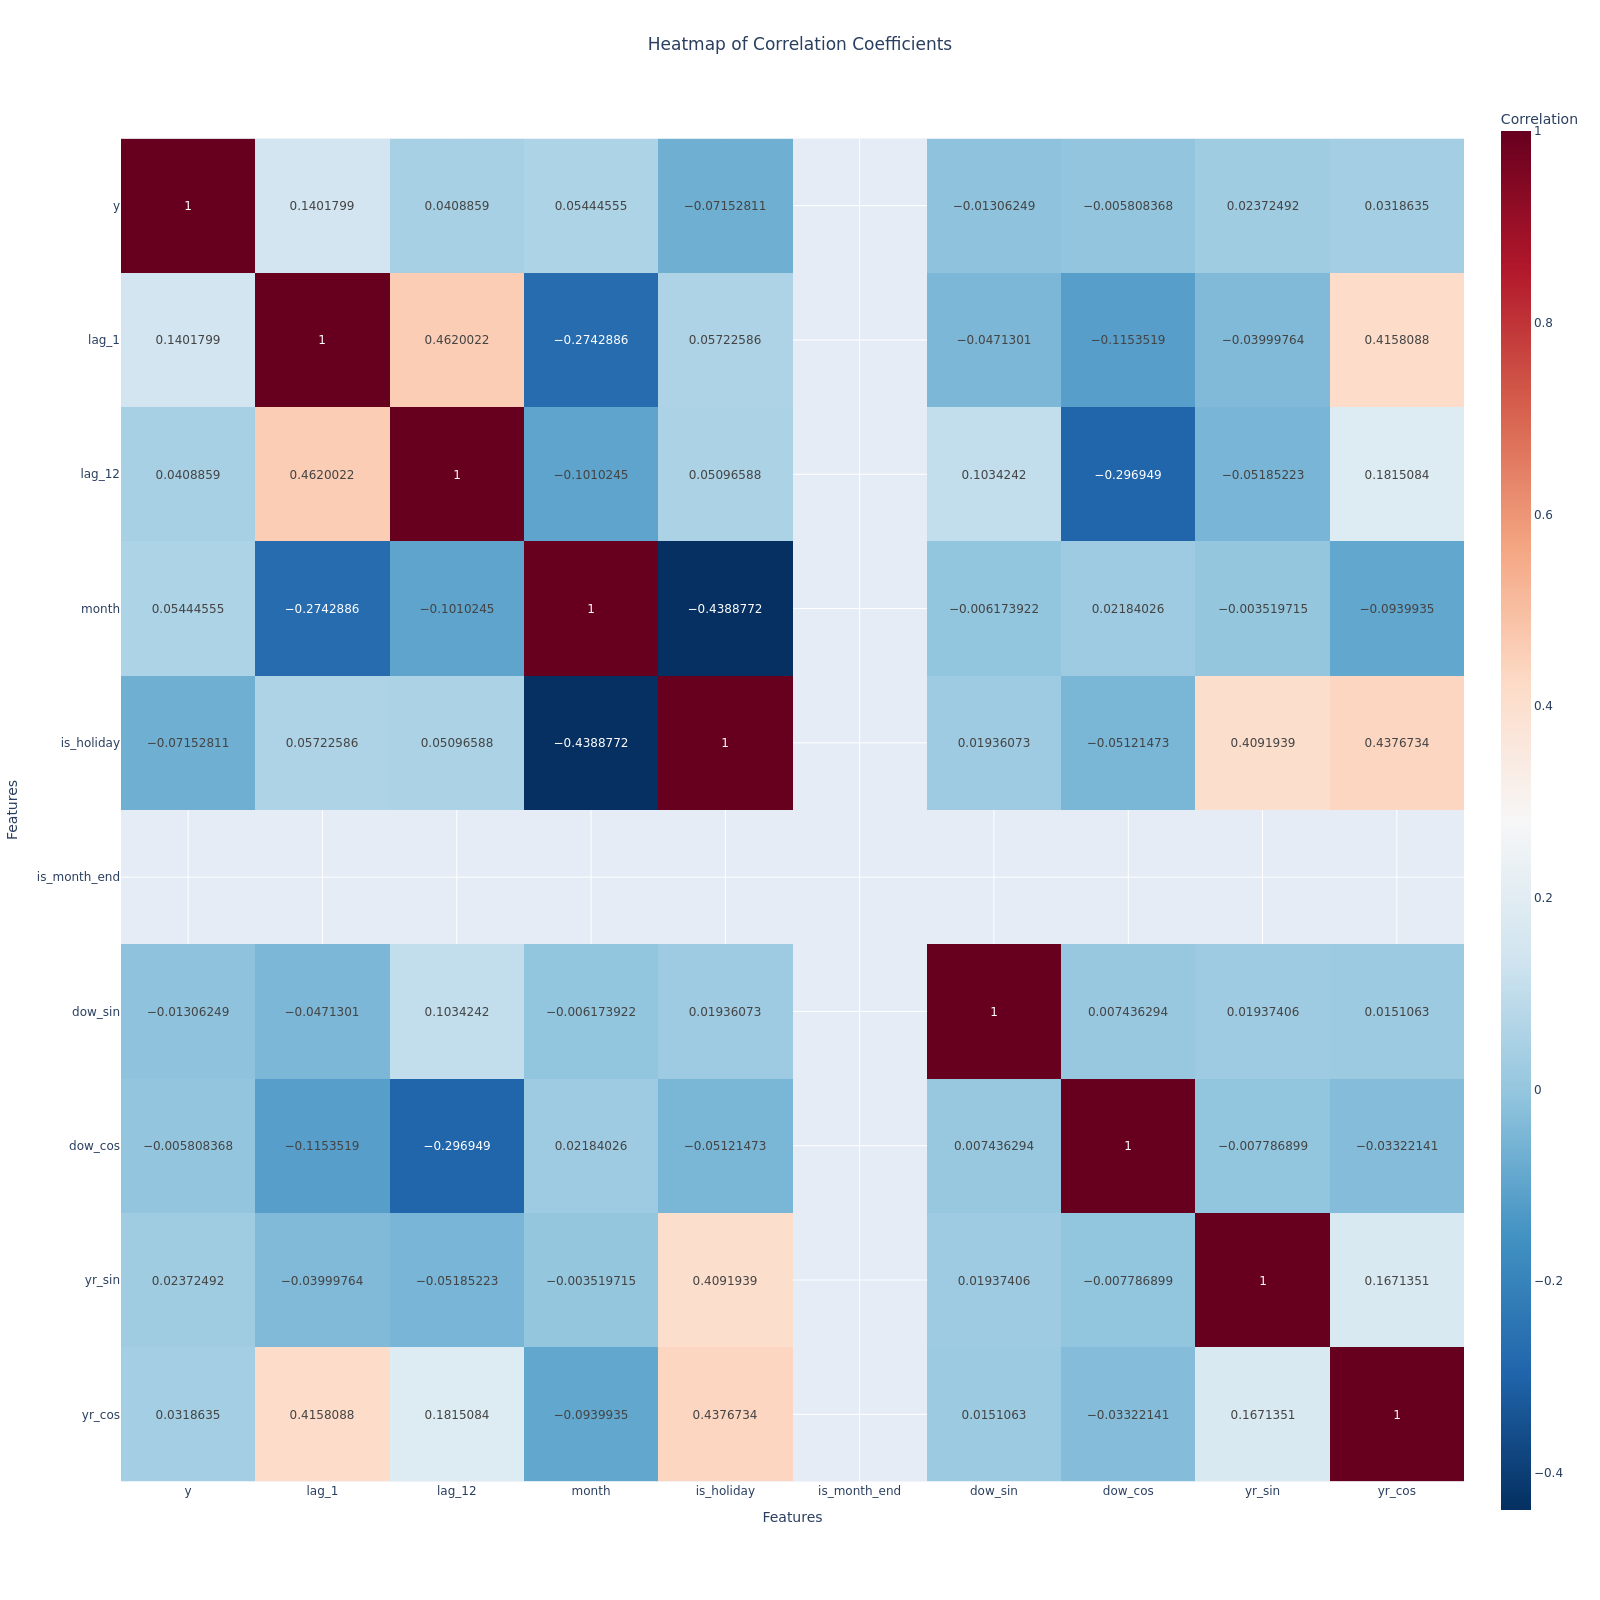

In [294]:
corr_heatmap(df[df.columns[2:]], fig_type="png")

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva